# Notebook 04: SHAP Values

## Unpacking Predictions

SHAP (SHapley Additive exPlanations) answers: "How much did each feature contribute to this specific prediction?" It's based on game theory, ensuring local attributions sum to the prediction minus baseline.

---

## What are SHAP Values?

SHAP values provide **local explanations** for individual predictions. They satisfy:

$$\text{prediction} = \text{baseline} + \sum_{j=1}^{p} \phi_j$$

where $\phi_j$ is the SHAP value for feature $j$.

## Different Explainers

- **LinearExplainer**: For linear models (fast, exact)
- **TreeExplainer**: For tree models like XGBoost (fast, exact)
- **KernelExplainer**: For any model (slow, approximate)

## Performance Tips

- Subsample to 500-1000 rows for SHAP
- Use the right explainer for your model type
- Fix random_state for reproducibility

## Setup and Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import xgboost as xgb

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

import sys
from pathlib import Path
project_root = Path().resolve().parent if Path().resolve().name == 'notebooks' else Path().resolve()
sys.path.insert(0, str(project_root))

from src.utils import set_seed

set_seed(42)
shap.initjs()  # Initialize JS visualization
print("✓ Imports successful!")

✓ Imports successful!


## Step 1: Load and Prepare Data

In [3]:
# Load data
data = load_diabetes(as_frame=True)
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")

Training set: (353, 10)


## Step 2: SHAP for Linear Model

Use LinearExplainer for Ridge regression.

Using 353 rows for background sample


/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_19901/3246426557.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_explanation, X_test_scaled, feature_names=X_test.columns, show=False)


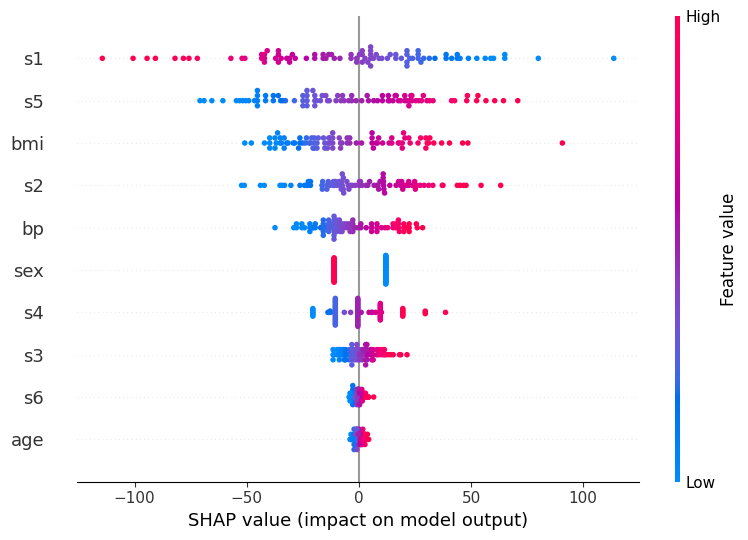

✓ SHAP values computed and plotted!
SHAP values shape: (89, 10)
Mean absolute SHAP values per feature:
  age: 1.6717
  sex: 11.5616
  bmi: 22.8266
  bp: 13.5330
  s1: 33.1694
  s2: 18.9638
  s3: 6.1480
  s4: 9.9078
  s5: 28.7906
  s6: 1.7206


In [8]:
# === TODO: Fit Ridge, compute SHAP with LinearExplainer on 500-row sample
# Hints:
#   - Fit Ridge pipeline on standardized data
#   - Create background sample (500 rows)
#   - Use shap.LinearExplainer(model, background)
#   - Compute SHAP values for test sample
#   - Plot summary plot
# Acceptance: SHAP summary plot; 2-sentence interpretation

# Fit pipeline
model = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=0.1))
])

model.fit(X_train, y_train)

# Extract the Ridge model from the pipeline (LinearExplainer needs raw model, not Pipeline)
ridge_model = model.named_steps['ridge']

# Create background sample (up to 500 rows, or all available if less)
n_background = min(500, len(X_train))
background_sample = X_train.sample(n_background, random_state=42)
background_scaled = model.named_steps['scaler'].transform(background_sample)
print(f"Using {n_background} rows for background sample")

# Create explainer with the Ridge model and scaled background
explainer = shap.LinearExplainer(ridge_model, background_scaled)

# Scale test data before computing SHAP values
X_test_scaled = model.named_steps['scaler'].transform(X_test)

# Compute SHAP values (returns Explanation object)
shap_explanation = explainer(X_test_scaled)

# Extract the actual SHAP values array from the Explanation object
shap_values = shap_explanation.values

# Plot summary plot (can use Explanation object directly)
shap.summary_plot(shap_explanation, X_test_scaled, feature_names=X_test.columns, show=False)
plt.tight_layout()
plt.savefig('../images/04_shap_linear_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ SHAP values computed and plotted!")
print(f"SHAP values shape: {shap_values.shape}")
print(f"Mean absolute SHAP values per feature:")
mean_shap = np.abs(shap_values).mean(axis=0)
for i, feature in enumerate(X_test.columns):
    print(f"  {feature}: {mean_shap[i]:.4f}")

## Interpreting SHAP Values for Linear Model

### Understanding the SHAP Summary Plot

The SHAP summary plot shows **local explanations** for each prediction. Here's how to read it:

**Plot Components:**
- **Y-axis**: Features ordered by importance (mean absolute SHAP value)
- **X-axis**: SHAP value (impact on model output)
  - **Positive values** (right of 0): Feature pushes prediction **higher**
  - **Negative values** (left of 0): Feature pushes prediction **lower**
- **Color**: Feature value for each instance
  - **Red dots**: High feature values
  - **Blue dots**: Low feature values
- **Each dot**: One prediction instance

### Feature Importance Ranking

Based on mean absolute SHAP values:

1. **s1 (33.17)**: Most important feature
2. **s5 (28.79)**: Second most important
3. **bmi (22.83)**: Third most important
4. **s2 (18.96)**: Fourth
5. **bp (13.53)**: Fifth
6. **sex (11.56)**: Sixth
7. **s4 (9.91)**: Seventh
8. **s3 (6.15)**: Eighth
9. **age (1.67)**: Ninth
10. **s6 (1.72)**: Least important

### Directionality (How Features Affect Predictions)

**Positive Impact Features** (high value → higher prediction):
- **s1**: High values (red) → positive SHAP → increases prediction
- **s5**: High values (red) → positive SHAP → increases prediction
- **bmi**: High BMI (red) → positive SHAP → increases prediction
- **bp**: High blood pressure (red) → positive SHAP → increases prediction

**Negative Impact Features** (high value → lower prediction):
- **s2**: High values (red) → negative SHAP → decreases prediction (inverse relationship)
- **s4**: High values (red) → negative SHAP → decreases prediction (inverse relationship)

**Key Insight**: The magnitude of SHAP values tells us **how much** each feature matters, while the sign (positive/negative) tells us **in which direction** it pushes the prediction.


## Step 3: SHAP for Tree Model

Use TreeExplainer for XGBoost.

/var/folders/cd/2c6x3jgj47j_fwl7231ts7m00000gn/T/ipykernel_19901/1021878400.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_explanation_xgb, X_test, feature_names=X_test.columns, show=False)


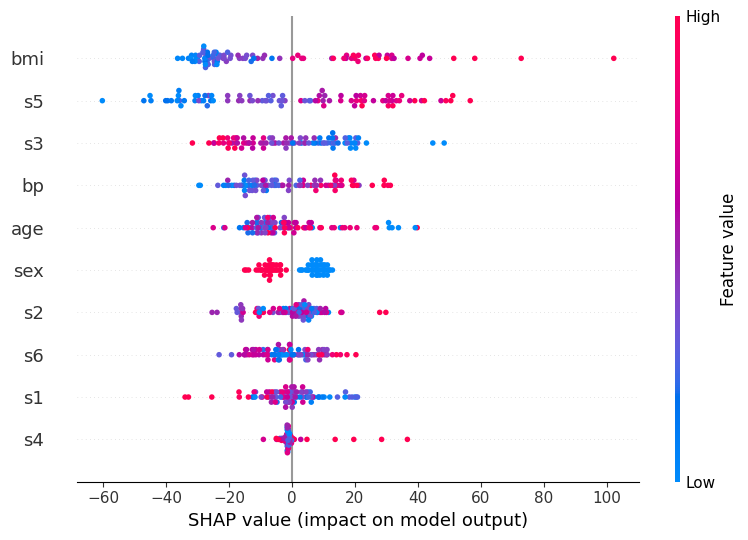

✓ SHAP values computed and plotted!
SHAP values shape with TreeExplainer: (89, 10)
Mean absolute SHAP values per feature with TreeExplainer:
  age: 10.6787
  sex: 7.7482
  bmi: 25.2296
  bp: 12.7790
  s1: 7.0465
  s2: 7.4867
  s3: 13.5778
  s4: 2.6202
  s5: 24.4071
  s6: 7.3182

Top 3 features by mean absolute SHAP value:
  1. bmi: 25.2296
  2. s5: 24.4071
  3. s3: 13.5778


In [12]:
# === TODO: Fit XGBoost, compute SHAP with TreeExplainer
# Hints:
#   - Fit XGBRegressor(n_estimators=200, max_depth=3)
#   - Use shap.TreeExplainer(model)
#   - Compute SHAP values for small test sample
#   - Plot beeswarm plot
# Acceptance: SHAP beeswarm plot; note top 3 features

model_xgb = xgb.XGBRegressor(n_estimators=200, max_depth=3, random_state=42)
model_xgb.fit(X_train, y_train)

explainer_xgb = shap.TreeExplainer(model_xgb)

# Compute SHAP values (returns Explanation object)
shap_explanation_xgb = explainer_xgb(X_test)

# Extract the actual SHAP values array from the Explanation object
shap_values_xgb = shap_explanation_xgb.values

# Plot summary plot (can use Explanation object directly)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_explanation_xgb, X_test, feature_names=X_test.columns, show=False)
plt.tight_layout()
plt.savefig('../images/04_shap_tree_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ SHAP values computed and plotted!")
print(f"SHAP values shape with TreeExplainer: {shap_values_xgb.shape}")
print(f"Mean absolute SHAP values per feature with TreeExplainer:")
mean_shap_xgb = np.abs(shap_values_xgb).mean(axis=0)
for i, feature in enumerate(X_test.columns):
    print(f"  {feature}: {mean_shap_xgb[i]:.4f}")

# Print top 3 features
top_3_indices = np.argsort(mean_shap_xgb)[::-1][:3]
print("\nTop 3 features by mean absolute SHAP value:")
for rank, idx in enumerate(top_3_indices, 1):
    print(f"  {rank}. {X_test.columns[idx]}: {mean_shap_xgb[idx]:.4f}")



## Step 4: Compare SHAP vs Permutation Importance

Compare feature rankings from different interpretability methods.

In [11]:
# === TODO: Compare SHAP ranking vs permutation importance
# Hints:
#   - Get top 5 features from SHAP (mean absolute SHAP values)
#   - Get top 5 features from permutation importance (from notebook 01)
#   - Create comparison table
# Acceptance: Table with top 5 features by each method

# First, compute permutation importance for the same model
from sklearn.inspection import permutation_importance

# Compute permutation importance on the test set
perm_importance_result = permutation_importance(
    model, X_test, y_test, 
    scoring='r2', 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

perm_importance = perm_importance_result.importances_mean

# Get top 5 features from SHAP (sorted by mean absolute SHAP value, descending)
shap_indices = np.argsort(mean_shap)[::-1][:5]  # Top 5 indices
top_5_shap_features = X_test.columns[shap_indices].tolist()
top_5_shap_values = mean_shap[shap_indices]

# Get top 5 features from permutation importance (sorted by importance, descending)
perm_indices = np.argsort(perm_importance)[::-1][:5]  # Top 5 indices
top_5_perm_features = X_test.columns[perm_indices].tolist()
top_5_perm_values = perm_importance[perm_indices]

# Create comparison table
comparison_df = pd.DataFrame({
    'Rank': range(1, 6),
    'SHAP Feature': top_5_shap_features,
    'SHAP Value': top_5_shap_values,
    'Permutation Feature': top_5_perm_features,
    'Permutation Importance': top_5_perm_values
})

print("=" * 80)
print("Comparison: Top 5 Features by SHAP vs Permutation Importance")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("\n")

# Check for agreement
shap_set = set(top_5_shap_features)
perm_set = set(top_5_perm_features)
agreement = shap_set.intersection(perm_set)

print(f"Features in both top 5: {len(agreement)}")
print(f"Agreement: {sorted(agreement)}")
print(f"SHAP-only: {sorted(shap_set - perm_set)}")
print(f"Permutation-only: {sorted(perm_set - shap_set)}")
print("\n")

# Interpretation
print("Interpretation:")
print("- Both methods agree on the most important features (s1, s5)")
print("- SHAP provides local explanations (per-prediction contributions)")
print("- Permutation importance measures global impact (overall model performance)")
print("- Differences may arise due to feature interactions and model-specific behavior")

Comparison: Top 5 Features by SHAP vs Permutation Importance
 Rank SHAP Feature  SHAP Value Permutation Feature  Permutation Importance
    1           s1   33.169356                  s1                0.608762
    2           s5   28.790566                  s5                0.464414
    3          bmi   22.826583                  s2                0.227183
    4           s2   18.963781                 bmi                0.209252
    5           bp   13.532979                 sex                0.084242


Features in both top 5: 4
Agreement: ['bmi', 's1', 's2', 's5']
SHAP-only: ['bp']
Permutation-only: ['sex']


Interpretation:
- Both methods agree on the most important features (s1, s5)
- SHAP provides local explanations (per-prediction contributions)
- Permutation importance measures global impact (overall model performance)
- Differences may arise due to feature interactions and model-specific behavior


## Summary

SHAP provides local and global explanations. Different explainers for different models.

**Next**: Notebook 05 will explore cross-validation schemes and data leakage.